# Dynamics of Jupiter Trojans

In the previous exercise we learned how to model the solar system's major bodies and study their long-term dynamical behavior. But the solar system also contains millions of minor planets. The Minor Planet Center, the organization that keeps track of new discoveries, currently lists 1.25 million asteroids, and more are discovered every day. Take a minute to look up the MPC's information about Polymele [here](https://minorplanetcenter.net/db_search/show_object?utf8=%E2%9C%93&object_id=Polymele). 

In this notebook, we'll see how to pull the orbital elements of asteroids from the MPC in a batch. We'll use the `spacerocks` package which we introduced last time to compute the current distribution of Jupiter Trojans on the sky right now. Then we'll zero in on the Lucy targets to show how they orbit stably around the L4 or L5 Lagrange points. 


> ![](https://www.nasa.gov/sites/default/files/thumbnails/image/jupiter_trojans-slower.gif)

In [1]:
# Import the tools we need
from spacerocks import SpaceRock, Units
from spacerocks.simulation import Simulation

import numpy as np

from astropy.time import Time
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u

from astroquery.jplhorizons import Horizons

from matplotlib import pyplot as plt
%matplotlib inline

`Spacerocks` uses a class called -- wait for it -- `SpaceRock` to describe a minor planet. There are several ways to create a `SpaceRock` object:
* You can initialize it from JPL Horizons: `polymele = SpaceRock.from_horizons('Polymele')`
* You can initialize it by supplying orbital elements yourself: `polymele = SpaceRock(a= 5.1803012*u.au, e=0.0967597, inc=12.98132*u.deg,... etc.)` 
* You can initialize it with a batch of many objects all at once. In the above step, you'd simply pass vectors of elements instead of single values. We'll see another way to do this below.



In [2]:
# Example:
polymele = SpaceRock.from_horizons('Polymele')

In [3]:
# This displays Polymele's semi-major axis, eccentricity, inclination, ascending node, argument of perihelion, and time of perihelion.
# The last parameter, epoch, is the epoch at which these elements were calculated. 
print(polymele.a.au, polymele.e, polymele.inc.deg, polymele.node.deg, polymele.arg.deg, polymele.t_peri.iso, polymele.epoch.iso) 

[5.18013969] [0.09674728] [12.98135825] [50.31886686] [4.75418766] ['2021-09-12 17:20:07.820'] ['2023-02-11 00:00:00.000']


With a `SpaceRock` in hand, you can add it to a simulation and use the N-body integrator to propagate it to an arbitrary epoch in the past or future. Because asteroids have much, much smaller masses than the sun and planets, the simulation treats `SpaceRocks` as test particles: they feel the gravity of the major bodies in the simulation, but do not perturb them. This speeds up the integrations considerably, at negligible cost to the accuracy.

---

A `SpaceRock` can also contain a vector of many objects. In fact, it can contain every asteroid known to the MPC. Let's do that now:


In [5]:
# This extracts all known asteroid orbital elements from the MPC (takes a minute or so)
all_asteroids = SpaceRock.from_mpc('mpcorb_extended', download_data=False, metadata=['Orbit_type', 'Name'])

Output()

In [6]:
N_asteroids = len(all_asteroids)
print(f'There are {N_asteroids} asteroids known to the Minor Planet Center!')

There are 1266015 asteroids known to the Minor Planet Center!


We can use this full list to answer a question that was raised early in the semester: What is the probability of random overlap with another asteroid during an occultation? In other words, could the 2022 detection of "Shaun" have been just an accidental detection of an unrelated asteroid that happened to lie along the same line of sight? We can estimate an answer to this question by computing the position of every asteroid at some arbitrary moment in time, and looking for close pairs. The separation would need to be on the order of a few milli-arcseconds to be detected together in an occultation.

We will use `SpaceRocks`' approximate propagation method called `analytic_propagate`, and "observe" every asteroid from the earth geocenter. These approximations mean that our calculation will not be completely accurate, but here we are interested in the distribution of separations, which should be relatively independent of these details.

In [7]:
date = Time('2023-02-04', scale='utc', format='iso')

units = Units()
units.timescale = 'utc'
prop = all_asteroids.analytic_propagate(epoch=date.jd)
obs = prop.observe(obscode='500')    # compute sky positions as seen from the earth geocenter

pos = SkyCoord(obs.ra.deg, obs.dec.deg, frame='icrs', unit=(u.deg, u.deg))

/Users/gerdes/.conda/envs/lucy/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 5 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


0.0


In [8]:
# find closest object to each asteroid. Don't use nthneighbor=1 because every object is closest to itself.
ind, sep2d, sepd3 = match_coordinates_sky(pos, pos, nthneighbor=2) 

(0.0, 2.0)

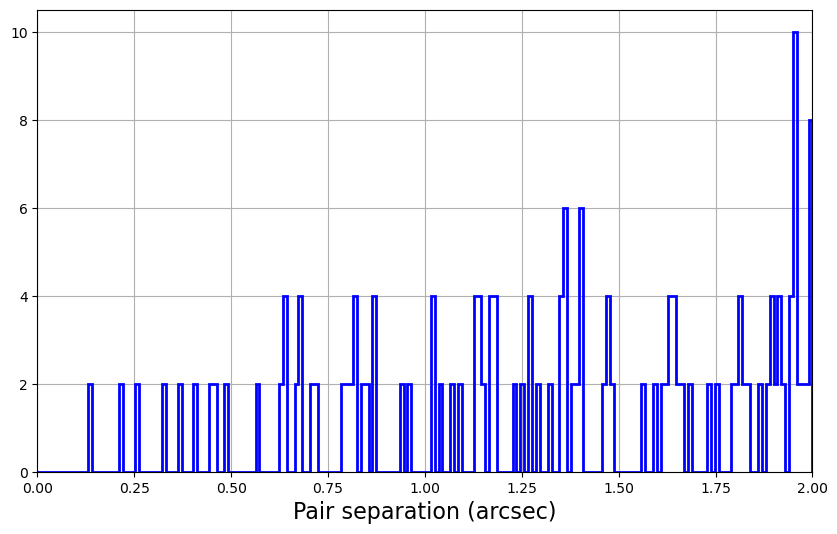

In [10]:
# Plot a histogram of close separations. 
# To be detectable in an occultation, a pair would need to be in the very first bin.

fig, ax = plt.subplots(1, figsize=(10,6))
n, bins, patches = plt.hist(sep2d.arcsec, bins=np.linspace(0,2,200), histtype='step', color='b', lw=2)
ax.grid()
ax.set_xlabel('Pair separation (arcsec)', fontsize=16)
ax.set_xlim([0,2])

In [11]:
# Examine the closest pair:
min_sep = np.min(sep2d.arcsec)
first_index = np.argmin(sep2d.arcsec)
matched_index = ind[first_index]
print(f'Closest pair: ({prop[first_index].name}, {prop[matched_index].name}), separation: {round(min_sep,4)} arcsec.')
print(f'Position 1: {prop[first_index].name}: {obs[first_index].ra.deg}, {obs[first_index].dec.deg}, earth_distance={obs[first_index].delta}')
print(f'Position 2: {prop[matched_index].name}: {obs[matched_index].ra.deg}, {obs[matched_index].dec.deg}, , earth_distance={obs[matched_index].delta}')

Closest pair: (2009 RE4, 2004 DL19), separation: 0.1323 arcsec.
Position 1: 2009 RE4: 335.32421440201415, -10.578686952142085, earth_distance=3.437284649913825 AU
Position 2: 2004 DL19: 335.3242507155178, -10.578695670500233, , earth_distance=3.3954130783466296 AU


Out of 1.25 million asteroids, the closest pair is 132 milliarcseconds apart. This about 10x too far apart to be detected together during a typical occultation measurement. For the two main belt asteroids above, at their earth distances of about 3.4 AU, their angular separation of 132 mas corresponds to a ground-track separation of over 300 km.

Of course this is not a systematic statistical study. And we only considered overlap between known asteroids, not small, unknown ones. However this simple exercise does suggest that the probability of accidental overlap with any particular astroid in an occultation is quite small... probably less than one in a million.

---
# Plotting the Jupiter Trojans

The full asteroid catalog is an inconveniently large list, so let's extract just the known Jupiter Trojans. (This is why we included the `Orbit_type` metadata above.)

In [12]:
trojans = all_asteroids[all_asteroids.Orbit_type == 'Jupiter Trojan']
N_trojans = len(trojans)
print(f'There are {N_trojans} Jupiter Trojans known to the Minor Planet Center!')

There are 12404 Jupiter Trojans known to the Minor Planet Center!


In [13]:
# Polymele is in this group, let's pull it out:
polymele_mpc = trojans[trojans.Name=='Polymele']
print(polymele_mpc.a.au, polymele_mpc.e, polymele_mpc.inc.deg, polymele_mpc.node.deg, polymele_mpc.arg.deg, polymele_mpc.name, polymele_mpc.t_peri.iso, polymele.epoch.iso) 

[5.1803012] [0.0967597] [12.98132] [50.31857] [4.77157] ['1999 WB2'] ['2021-09-12 21:21:28.808'] ['2023-02-11 00:00:00.000']


Note that there are small differences between the elements obtained from JPL Horizons and those from the MPC, even though they are referenced to the same epoch. I'm not sure if this is a real discrepancy or a slight difference in the way the orbits are fit.

---

# Plotting the Trojans' positions

Now let's plot the Trojans' approximate positions on the sky on the night of the Polymele occultation, Feb. 4, 2023.  We will use SpaceRock's `analytic_propagate` method, which is much faster than a full ephemeris-quality integration. (We are just trying to get a general picture.) We will also get the positions of Jupiter, the moon, and the bright comet C/2022 E3 (Comet ZFT) from Horizons.

In [14]:
date = Time('2023-02-04', scale='utc', format='iso')

units = Units()
units.timescale = 'utc'
prop = trojans.analytic_propagate(epoch=date.jd)
obs = prop.observe(obscode='500')    # compute sky positions as seen from the earth geocenter

0.0


In [15]:
# Moon and Jupiter from Horizons
startdate = Time('2023-02-03 02:00', scale='utc', format='iso')
enddate = Time('2023-02-03 02:30:00', scale='utc', format='iso')
Salina_KS = {'lat':37.779557, 'lon':-97.618487, 'elevation':864}   # Salina, Kansas
Jupiter_ID, moon_ID = '599', '301'

observer_loc = Salina_KS
jupiter = Horizons(id=Jupiter_ID, location=observer_loc,
                epochs={'start':startdate.iso, 
                        'stop':enddate.iso, 
                        'step':'1h'}).ephemerides().to_pandas()


moon = Horizons(id=moon_ID, location=observer_loc,
                epochs={'start':startdate.iso, 
                        'stop':enddate.iso, 
                        'step':'1h'}).ephemerides().to_pandas()

# And comet ZTF, because we might get a look at it!

comet_ZTF = Horizons(id='C/2022 E3', location=observer_loc,
                     epochs={'start':startdate.iso,
                        'stop':enddate.iso, 
                        'step':'1h'}).ephemerides().to_pandas()


In [16]:
pos_moon = SkyCoord(moon.RA[0], moon.DEC[0], frame='icrs', unit=(u.deg, u.deg))
pos_star = SkyCoord(99.727734,	36.024221, frame='icrs', unit=(u.deg, u.deg)) # The star that will be occulted by Polymele
print(pos_moon.separation(pos_star).deg, moon.illumination[0])
pos_comet = SkyCoord(comet_ZTF.RA[0], comet_ZTF.DEC[0], frame='icrs', unit=(u.deg, u.deg))

10.930694297638224 93.79655


The above is a reminder of what we found in the Asteroid Ephemerides exercise: the target star is less than 11 degrees from a nearly full moon.

In [20]:
print(comet_ZTF.EL[0], comet_ZTF.AZ[0])
print(pos_comet.to_string(style='hmsdms', sep=':'))

61.305695 20.06274
05:45:30.1248 +63:20:56.184


/var/folders/wn/xn44zh2d4q94055t5mqw7c180000gs/T/ipykernel_45991/3792441751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ra[ra>180] -= 360


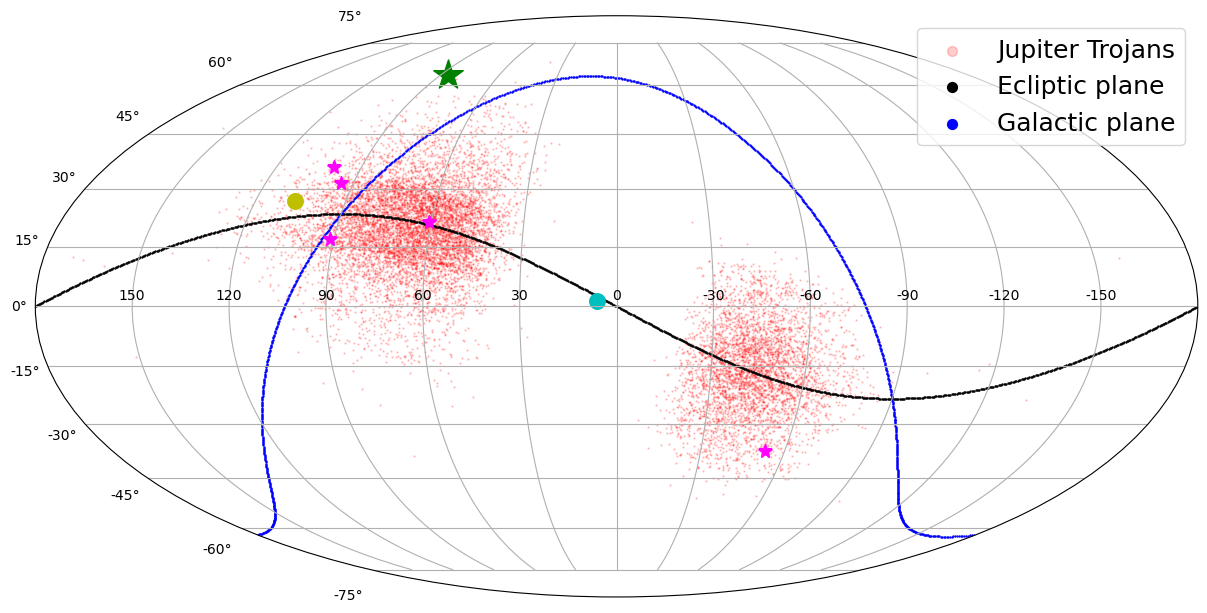

In [21]:
# Helper function for coordinate conversion
def radec2project(ra, dec):
    ra[ra>180] -= 360
    return (-np.radians(ra), np.radians(dec))

ecliptic = SkyCoord(np.linspace(0,360,1000), np.zeros(1000), unit=(u.deg, u.deg), frame='geocentrictrueecliptic').transform_to('icrs')
galactic = SkyCoord(np.linspace(0,360,1000), np.zeros(1000), unit=(u.deg, u.deg), frame='galactic').transform_to('icrs')

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111, projection="mollweide")
x, y = radec2project(obs.ra.deg, obs.dec.deg)
ax.scatter(x, y, marker='.', s=2, color='r', alpha=0.2, label='Jupiter Trojans')
x, y = radec2project(ecliptic.ra.deg, ecliptic.dec.deg)
ax.scatter(x, y, marker='.',color='k', s=2, label='Ecliptic plane')
x, y = radec2project(galactic.ra.deg, galactic.dec.deg)
ax.scatter(x, y, marker='.', s=2,color='b', label='Galactic plane')
x, y = radec2project(jupiter.RA, jupiter.DEC)
ax.scatter(x[0], y[0], marker='.', s=500, color='c')
x, y = radec2project(moon.RA, moon.DEC)
ax.scatter(x[0], y[0], marker='.', s=500, color='y')
x, y = radec2project(comet_ZTF.RA, comet_ZTF.DEC)
ax.scatter(x[0], y[0], marker='*', s=500, color='green')
# Plot the Lucy targets explicitly:
Lucy_targets = ['1973 SO', '1999 WB2', '1997 TS25', '1999 VQ10', 'A906 UL'] # Spacerocks uses the alphanumeric designations
for target in Lucy_targets:
  rock = obs[obs.name==target]
  x, y = radec2project(np.array(rock.ra.deg), np.array(rock.dec.deg))
  ax.plot(x, y, marker='*', markersize=10, color='magenta')
ax.set_xticklabels((150, 120, 90, 60, 30, 0, -30, -60, -90, -120, -150))
ax.legend(fontsize=18, markerscale=10)
plt.grid(True)

In the plot above you can see the two Trojan "camps": the L4 group on the left, and the L5 group on the right. They lead/trail Jupiter (cyan circle) by ~60 degrees of ecliptic latitude respectively. On the night of 2/4/23 the moon (yellow circle) is rather close to the L4 group. (Polymele is the northernmost and easternmost magenta starred object above.) The 12,000+ known Trojans cover a wide area of sky! 

Also note that on the night of the occultation, the new "Green Comet" (C/2022 E3, also called Comet ZTF) will be north and a little west of Polymele, around 8th magnitude.

----

# Long-term Trojan Dynamics

There are five Lagrange points, special points at which the gravitational force from the two masses (e.g. the sun and the earth) balances the centripetal force needed to keep an object orbiting at that location. The L1, L2, and L3 points are unstable. (This is why the James Webb Space Telescope, which orbits near earth's L2 point, needs to expend fuel for station-keeping.) However, the L4 and L5 points, where the Trojans live, are stable: an object placed there in the correct initial state can remain in a stable orbit there for the lifetime of the solar system. Most Jupiter Trojans are thought to be relics of the solar system's early history, which is why they are being intensively studied by Lucy.

<img src="https://solarsystem.nasa.gov/internal_resources/813" width=500 />

This plot shows that the equipotential lines near L4 and L5 are large and somewhat "kidney-bean" shaped. You might imagine that a marble placed in a bowl with this shape would roll around in the same general pattern. Let's see what the Trojans do.

To model the Trojans, we will use a somewhat simplified picture of the solar system. We'll include the sun and the four giant planets, but not the rocky terrestrial planets or the large asteroids. Also, we will treat the Trojans as "test particles": they experience the gravity of the major bodies, but do not perturb them themselves. This is similar to the concept of a test charge in electrostatics. This approximation saves a great deal of time in the simulation without significant loss of accuracy.

In [22]:
# Set up the simulation parameters.

ast_name = 'Polymele'

units = Units()
units.timescale = 'tdb'
units.mass = u.M_sun

sim = Simulation(model='GIANTS', epoch='01 Jan 2022', units=units) # `epoch` is the start time of our integration
rock = SpaceRock.from_horizons(ast_name)
sim.add_spacerocks(rock)

sim.integrator = 'mercurius'


In [23]:
# Initially, we will integrate for just over one 12-year orbital period of Jupiter

sim.dt = 1  # use a small timestep for this
t0 = sim.epoch.tdb.jd
tf = t0 + 13*365.25   
epochs = np.arange(t0, tf, 1)  # evaluate at 1-day intervals

prop, planets, sim = sim.propagate(epochs=epochs, units=units, exact_finish_time=0)
jup = planets[planets.name == 'Jupiter Barycenter'] 
ast = prop[prop.name == ast_name] 

Output()

In [24]:
jup_angle = jup.true_longitude 
rot = jup_angle - jup_angle[0] # Jupiter rotates through this angle for each step 
x_jup = jup.x.au * np.cos(-rot) - jup.y.au * np.sin(-rot)
y_jup = jup.x.au * np.sin(-rot) + jup.y.au * np.cos(-rot)
x_ast = ast.x.au * np.cos(-rot) - ast.y.au * np.sin(-rot)
y_ast = ast.x.au * np.sin(-rot) + ast.y.au * np.cos(-rot)
# L4 leads Jupiter by 60 degrees
rot_L4 = rot.rad - 60*u.deg.to(u.rad)
x_L4 = jup.x.au * np.cos(-rot_L4) - jup.y.au * np.sin(-rot_L4)
y_L4 = x_jup = jup.x.au * np.sin(-rot_L4) + jup.y.au * np.cos(-rot_L4)

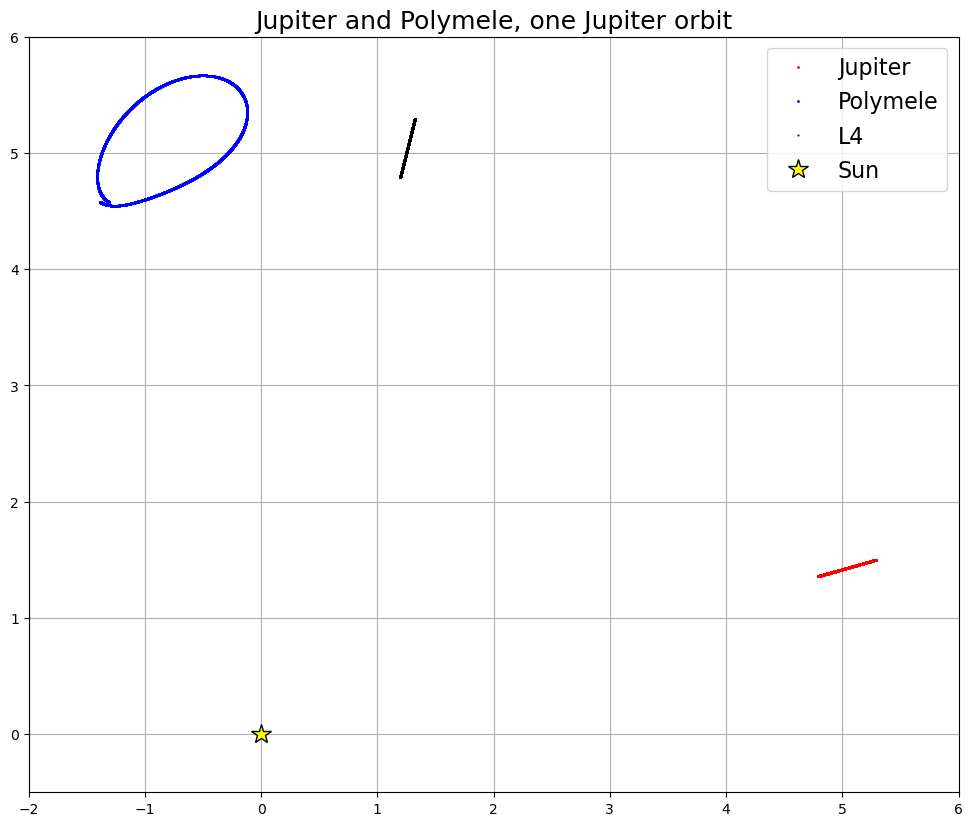

In [39]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x_jup, y_jup, '.', color='r', markersize=2, label='Jupiter')
ax.plot(x_ast, y_ast, '.', color='blue', markersize=2, label=ast_name)
ax.plot(x_L4, y_L4, '.', color='k',  markersize=1, label='L4')
ax.plot(0, 0, '*', color='yellow', markeredgecolor='k', markersize=15, label='Sun')
ax.grid()
ax.set_xlim([-2, 6])
ax.set_ylim([-0.5, 6])
ax.set_aspect('equal')
leg = ax.legend(fontsize=16)
txt = ax.set_title(f'Jupiter and {ast_name}, one Jupiter orbit', fontsize=18)

This is a very interesting plot! 


*   In the co-rotating frame, <b>Jupiter</b> (red points) just moves on a radial line. Its distance to the sun, which is located at (0,0), varies due to Jupiter's eccentric orbit.
* The <b> L4 point</b> simply mirrors Jupiter's motion, 60 degrees ahead.
*   <b>Polymele</b> executes one loop around a point near L4. This is called <i>epicyclic</i> motion.



In [40]:
# Repeat the procedure above, but now for 30 Jupiter orbits (about 360 years)

sim.dt = 10  # increase the timestep
t0 = sim.epoch.tdb.jd
tf = t0 + 30*12*365.25     
epochs = np.arange(t0, tf, 10)  # evaluate at 10-day intervals

prop, planets, sim = sim.propagate(epochs=epochs, units=units, exact_finish_time=0)
jup = planets[planets.name == 'Jupiter Barycenter'] 
ast = prop[prop.name == ast_name] 

Output()

In [41]:
jup_angle = jup.true_longitude 
rot = jup_angle - jup_angle[0] # Jupiter rotates through this angle for each step 
x_jup = jup.x.au * np.cos(-rot) - jup.y.au * np.sin(-rot)
y_jup = jup.x.au * np.sin(-rot) + jup.y.au * np.cos(-rot)
x_ast = ast.x.au * np.cos(-rot) - ast.y.au * np.sin(-rot)
y_ast = ast.x.au * np.sin(-rot) + ast.y.au * np.cos(-rot)
# L4 leads Jupiter by 60 degrees
rot_L4 = rot.rad - 60*u.deg.to(u.rad)
x_L4 = jup.x.au * np.cos(-rot_L4) - jup.y.au * np.sin(-rot_L4)
y_L4 = x_jup = jup.x.au * np.sin(-rot_L4) + jup.y.au * np.cos(-rot_L4)

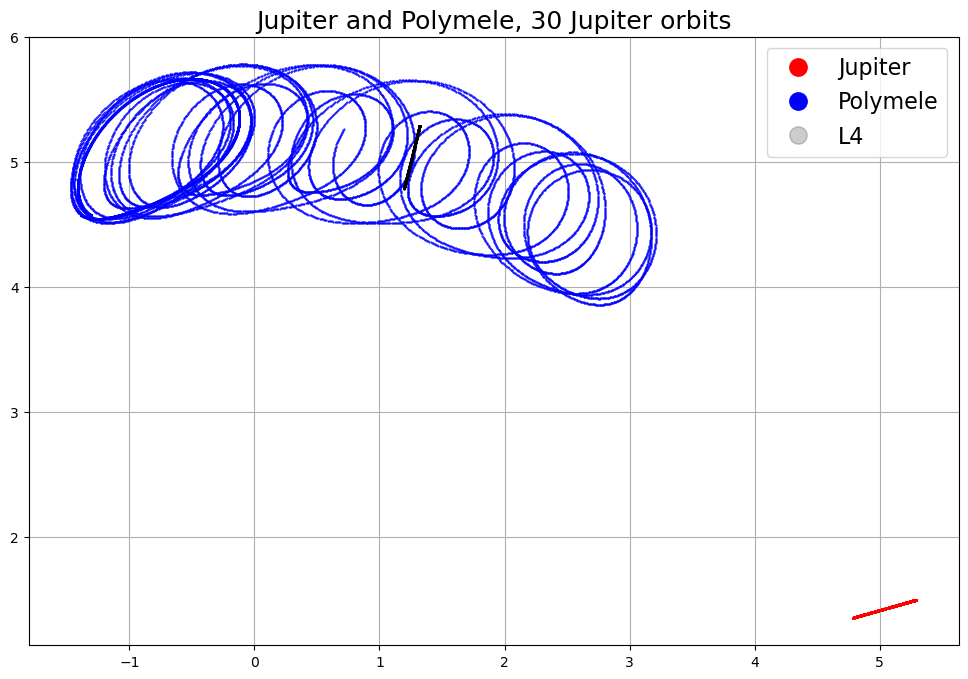

In [42]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x_jup, y_jup, '.', color='r', markersize=1, label='Jupiter')
ax.plot(x_ast, y_ast, '.', color='blue', markersize=1, label=ast_name)
ax.plot(x_L4, y_L4, '.', color='k', alpha=0.2, markersize=1, label='L4')
ax.grid()
ax.set_aspect('equal')
leg = ax.legend(fontsize=16, markerscale=25)
txt = ax.set_title(f'Jupiter and {ast_name}, 30 Jupiter orbits', fontsize=18)

Plots like this show that there are many more solutions to Newton's laws than you might have thought! Over this longer period, it's clear that the Trojan is executing a set of loops that oscillate around L4. This motion is called <b>libration</b>, and it's characteristic of any object in a mean-motion resonance like this. 

We can make this idea more precise by defining the <b>libration angle</b> $\phi$. For the 1:1 resonance occupied by Trojans, this is simply the difference in the [mean longitudes](https://en.wikipedia.org/wiki/Mean_longitude) of the two bodies:
$$
\phi_{11} = \lambda_T - \lambda_J
$$
`SpaceRocks` calculates mean longitudes for us:

In [43]:
lambda_J = jup.mean_longitude.deg
lambda_T = ast.mean_longitude.deg
phi_11 = (lambda_T - lambda_J) % 360

Text(0, 0.5, 'Libration angle (deg)')

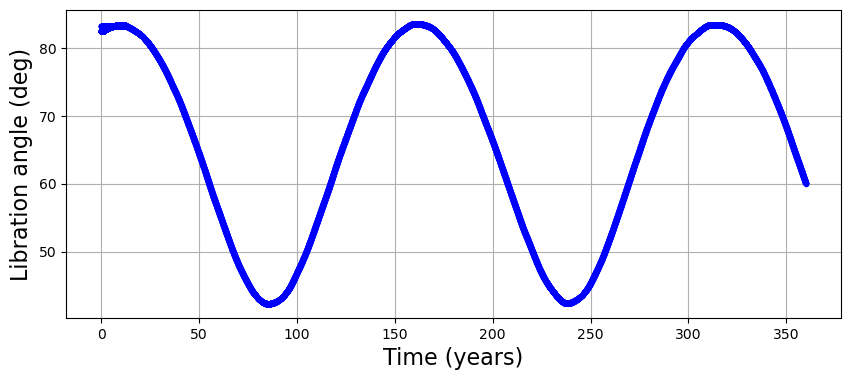

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))
t = (jup.epoch.jd - jup.epoch.jd[0])/(365.25)
sc = ax.plot(t, phi_11, '.', color='b')
ax.grid()
ax.set_xlabel('Time (years)', fontsize=16)
ax.set_ylabel('Libration angle (deg)', fontsize=16)

The libration angle undergoes oscillations with a period of about 150 years, and an amplitude of about 20 degrees.

---

# Long-term stability
A resonant object, such as a Trojan, is considered stable if its libration angle remains periodic and bounded. In physical terms, this means that the Trojan never leaves the stable potential well near the Lagrange point.

We'll conclude this notebook by doing a 10 million year integration to verify that Polymele is long-term stable.

In [47]:
# Set up the simulation parameters.

ast_name = 'Polymele'

units = Units()
units.timescale = 'tdb'
units.mass = u.M_sun

sim = Simulation(model='GIANTS', epoch='01 Jan 2022', units=units)
rock = SpaceRock.from_horizons(ast_name)
sim.add_spacerocks(rock)

sim.integrator = 'whfast'  # switch to the fastest integrator
sim.dt = 200

t0 = sim.epoch.tdb.jd
tf = t0 + 10_000_000*365.25   
epochs = np.arange(t0, tf, 100*365.25)  # evaluate at 100-year intervals

prop, planets, sim = sim.propagate(epochs=epochs, units=units, exact_finish_time=0)
jup = planets[planets.name == 'Jupiter Barycenter'] 
ast = prop[prop.name == ast_name] 

Output()

Text(0, 0.5, 'Libration angle (deg)')

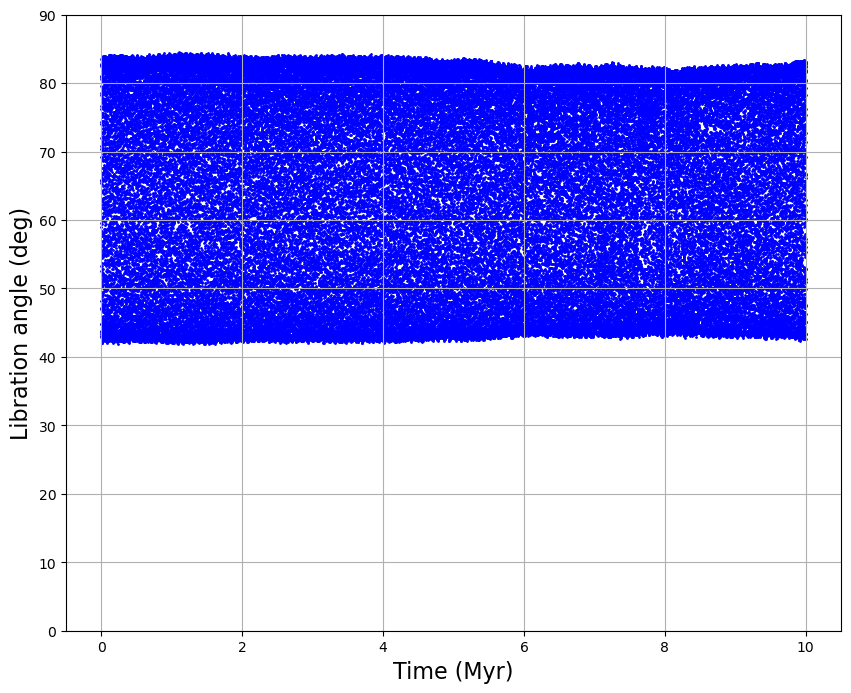

In [48]:
lambda_J = jup.mean_longitude.deg
lambda_T = ast.mean_longitude.deg
phi_11 = (lambda_T - lambda_J) % 360

fig, ax = plt.subplots(figsize=(10, 8))
t = (jup.epoch.jd - jup.epoch.jd[0])/(1_000_000*365.25)
sc = ax.scatter(t, phi_11, s=1, color='b')
ax.set_ylim([0, 90])
ax.grid()
ax.set_xlabel('Time (Myr)', fontsize=16)
ax.set_ylabel('Libration angle (deg)', fontsize=16)

The above result shows that the libration angle remains within about 20 degrees of the L4 point at 60 degrees, at least over a timescale of 10 million years. In fact, you can continue this integration for a billion years or more (I don't recommend doing this in Colab!) and verify that Polymele is in a stable orbit over timescales comparable to the lifetime of the solar system. It is truly a "fossil". 

----
# Homework (due Friday, 2/17)

* Repeat the above exercise for the Lucy target Patroclus, which is a L5 Trojan. You will need to change the asteroid name, and also modify the calculation of the Lagrange point in the plots to represent L5 rather than L4. What is Patroclus's libration amplitude?
* Neptune also has Trojans--they are possibly even more numerous than Jupiter Trojans. But because Neptune is much more distant (30 AU rather than 5), Neptune Trojans are much more difficult to discover, and we have only found about 30 of the largest ones. Build a simulation of the Neptune Trojan [2013 VX30](https://minorplanetcenter.net/db_search/show_object?utf8=%E2%9C%93&object_id=2013+VX30), which was discovered by our UM group and was the subject of [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0019103518304226?via%3Dihub). We recently observed this object with the James Webb Space Telescope.
    - Is 2013 VX30 a L4 or L5 Trojan?
    - Show that this object is stable for at least 10 million years, in a model solar system consisting of the 4 giant planets. (We think it's stable over billion-year+ timescales.)
    - What are its libration period and amplitude, approximately?